In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf

In [18]:
import tensorflow as tf

In [19]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Set the start and end dates
start_date = '2010-01-01'
end_date = '2023-10-31'

# Get the Apple stock data
apple_data = yf.download('AAPL', start=start_date, end=end_date)

# Print the head of the DataFrame
print(apple_data.head())

[*********************100%%**********************]  1 of 1 completed
                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2010-01-04  7.622500  7.660714  7.585000  7.643214   6.487534  493729600
2010-01-05  7.664286  7.699643  7.616071  7.656429   6.498751  601904800
2010-01-06  7.656429  7.686786  7.526786  7.534643   6.395380  552160000
2010-01-07  7.562500  7.571429  7.466071  7.520714   6.383555  477131200
2010-01-08  7.510714  7.571429  7.466429  7.570714   6.425995  447610800


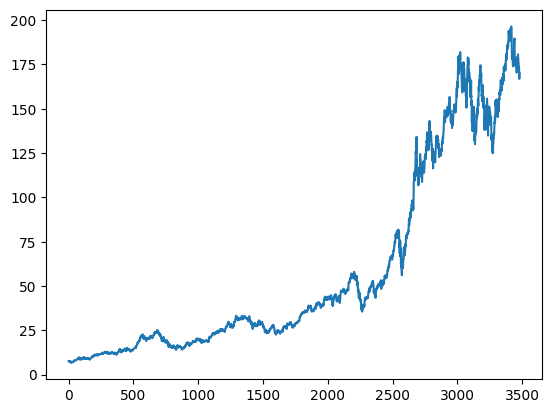

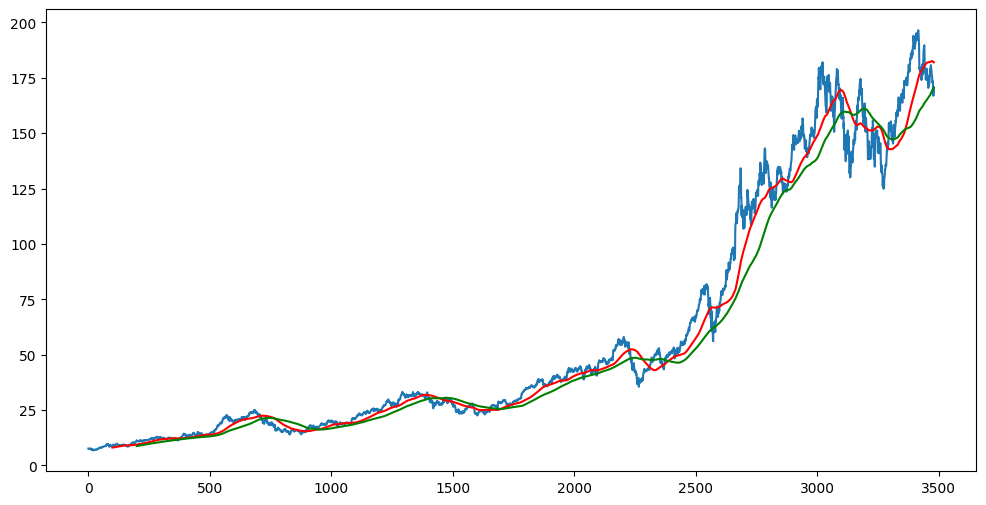

In [20]:
# Reset the index and drop unnecessary columns
apple_data.reset_index(inplace=True)
apple_data.drop(['Date', 'Adj Close'], axis=1, inplace=True)

# Plot the Close prices
plt.plot(apple_data['Close'])

# Calculate the moving averages
ma100 = apple_data['Close'].rolling(100).mean()
ma200 = apple_data['Close'].rolling(200).mean()

# Plot the moving averages
plt.figure(figsize=(12, 6))
plt.plot(apple_data['Close'])
plt.plot(ma100, 'r')
plt.plot(ma200, 'g')


In [21]:
# Splitting the data
train_data = pd.DataFrame(apple_data['Close'][:int(len(apple_data) * 0.70)])
test_data = pd.DataFrame(apple_data['Close'][int(len(apple_data) * 0.70):])

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.fit_transform(test_data)


In [22]:
x_train = []
y_train = []

# Prepare training data
for i in range(100, train_data.shape[0]):
    x_train.append(train_data_scaled[i - 100:i])
    y_train.append(train_data_scaled[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)


In [23]:
# Create and compile the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=60, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=80, activation='relu', return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(units=120))
model.add(Dropout(0.5))
model.add(Dense(units=1))
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error')


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100, 50)           10400     
                                                                 
 dropout_4 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_5 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_5 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_6 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_6 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_7 (LSTM)               (None, 120)              

In [25]:
# Train the model
model.fit(x_train, y_train, epochs=100, batch_size=32)
model.save('keras_model.h5')


Epoch 1/100
73/73 [==============================] - 7s 94ms/step - loss: 0.0050
Epoch 2/100
73/73 [==============================] - 7s 98ms/step - loss: 0.0045
Epoch 3/100
73/73 [==============================] - 7s 96ms/step - loss: 0.0044
Epoch 4/100
73/73 [==============================] - 7s 95ms/step - loss: 0.0042
Epoch 5/100
73/73 [==============================] - 7s 93ms/step - loss: 0.0040
Epoch 6/100
73/73 [==============================] - 7s 96ms/step - loss: 0.0042
Epoch 7/100
73/73 [==============================] - 7s 95ms/step - loss: 0.0031
Epoch 8/100
73/73 [==============================] - 7s 97ms/step - loss: 0.0040
Epoch 9/100
73/73 [==============================] - 7s 96ms/step - loss: 0.0033
Epoch 10/100
73/73 [==============================] - 7s 95ms/step - loss: 0.0029
Epoch 11/100
73/73 [==============================] - 7s 94ms/step - loss: 0.0027
Epoch 12/100
73/73 [==============================] - 7s 95ms/step - loss: 0.0031
Epoch 13/100
73/73 [=====

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
# Prepare test data
past_100_days = train_data.tail(100)
final_df = pd.concat([past_100_days, test_data], ignore_index=True)
input_data = scaler.fit_transform(final_df)

x_test = []
y_test = []

for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i - 100:i])
    y_test.append(input_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)


33/33 [==============================] - 1s 31ms/step


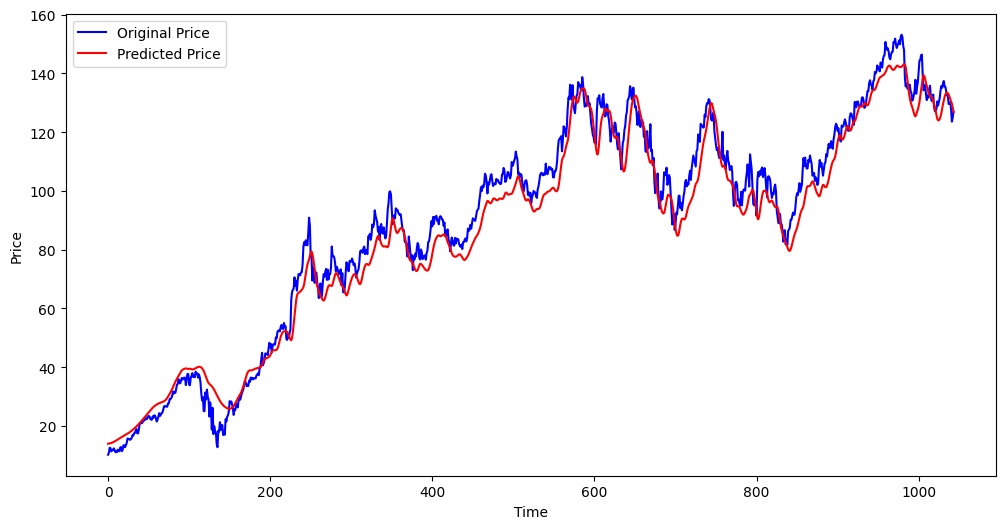

In [27]:
# Make predictions
y_predicted = model.predict(x_test)

# Inverse scaling to get actual prices
scale_factor = 1 / scaler.scale_[0]
y_predicted = y_predicted * scale_factor
y_test = y_test * scale_factor

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test, 'b', label='Original Price')
plt.plot(y_predicted, 'r', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

# Calculate metrics
mae = mean_absolute_error(y_test, y_predicted)
mse = mean_squared_error(y_test, y_predicted)
rmse = math.sqrt(mse)
r2 = r2_score(y_test, y_predicted)

# Display metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)


Mean Absolute Error (MAE): 5.365239512417963
Mean Squared Error (MSE): 42.46760565752329
Root Mean Squared Error (RMSE): 6.516717398930484
R-squared (R2) Score: 0.9692393956331306
